In [1]:
import torchdata
import torch
from gensim.models import FastText
import pandas as pd
import re
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy
import torchtext
from sklearn.model_selection import train_test_split
IGNORE_SAVED_FILES = True
print(torch.__version__, torch.cuda.is_available())

d:\5semak\NLP_5_semak\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0+cu116 True


In [ ]:
tags = ['<SOS>', '<EOS>', '<PAD>', '<UNK>', '<NAN>', '<NUM>', '<TIME>', '<ENUM>', '<DATE>', '<PHONE>', '<EMAIL>', '<SHORT>', '<NAME>']
tags_value = pd.DataFrame({'values': [i / (1+len(tags)) for i in range(1, 1+len(tags))]}, index=tags,)
tags_value.loc['<SOS>', 'values']


In [3]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1


def bad_patterns_to_tags_replaser(text: str):
    text = re.sub(r'\d+\:\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' <PHONE> ', text)
    text = re.sub('\d+/\d+/\d+', ' <DATE> ', text)
    text = re.sub('\d+-\d+-\d+', ' <DATE> ', text)
    text = re.sub('\d+th', ' <ENUM> ', text)
    text = re.sub('\d+rd', ' <ENUM> ', text)
    text = re.sub('\d+st', ' <ENUM> ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' <NUM> ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' <NUM> ', text)
    text = re.sub('\d+', ' <NUM> ', text)
    # text = re.sub(r'\w+\.', '<SHORT>', text[0:-1]) + '.'
    text = re.sub(',', ' , ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub(':', ' : ', text)
    text = re.sub('\?', ' \? ', text)
    text = re.sub('"', ' " ', text)
    text = re.sub("'", " ' ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\.', ' . ', text)
    text = re.sub('\(', ' ( ', text)
    text = re.sub('\)', ' ) ', text)
    text = re.sub('\.  \.  \.', ' ... ', text)
    text = re.sub('\s+', ' ', text)
    return text[0:-1]

bad_patterns_to_tags_replaser(
    "I'd wake up at 7:30 or 100:02:20, go... (downstairs), and the 123,45%, 123.45%, +123,45%, -123,45%, +123.45%, -123.45%, front phones [+7 999 444 55 66, +7-999-444-55-66, +79994445566, 79994445566, +7(999)-444-55-66, +7(999)-444-5566] door would be open - 600 beers in the kitchen and 20th, 3rd, 1st living room and nobody in the house on 12/12/2012 or 12-12-2012.".lower()
)



"i ' d wake up at <TIME> or <TIME> , go ... ( downstairs ) , and the <NUM> % , <NUM> % , <NUM> % , <NUM> % , <NUM> % , <NUM> % , front phones [ <PHONE> , <PHONE> , <PHONE> , <PHONE> , <PHONE> , <PHONE> ] door would be open - <NUM> beers in the kitchen and <ENUM> , <ENUM> , <ENUM> living room and nobody in the house on <DATE> or <DATE> ."

# Create Dataset

In [4]:
if not IGNORE_SAVED_FILES or not os.path.isfile('../Data/1mcorpus/data_p.csv'):
    if not os.path.isfile('../Data/1mcorpus/data.csv'):
        with open('../Data/1mcorpus/corpus.en_ru.1m.en', encoding='utf-8') as f:
            eng = f.read().split('\n')
        with open('../Data/1mcorpus/corpus.en_ru.1m.ru', encoding='utf-8') as f:
            rus = f.read().split('\n')
        data_csv = pd.DataFrame({'eng': eng, 'rus': rus}).dropna()
        data_csv_short = data_csv.loc[data_csv['eng'].apply(lambda a: len(a) < 32) | data_csv['rus'].apply(lambda a: len(a) < 32)]
        data_csv.to_csv('../Data/1mcorpus/data.csv', index=False)
        data_csv_short.to_csv('../Data/1mcorpus/data_short.csv', index=False)
    else:
        data_csv_short = pd.read_csv('../Data/1mcorpus/data_short.csv')
        data_csv = pd.read_csv('../Data/1mcorpus/data.csv')
    data_csv_normed = data_csv_short.dropna()
    data_csv_normed['eng'] = data_csv.dropna()['eng'].apply(bad_patterns_to_tags_replaser)
    data_csv_normed['rus'] = data_csv.dropna()['rus'].apply(bad_patterns_to_tags_replaser)
    data_csv_normed.to_csv('../Data/1mcorpus/data_p.csv', index=False)
    e_train, e_test, r_train, r_test = train_test_split(data_csv_normed['eng'], data_csv_normed['rus'])
    data_train = pd.DataFrame({'eng': e_train, 'rus': r_train})
    data_test = pd.DataFrame({'eng': e_test, 'rus': r_test})
    data_train.to_csv('../Data/1mcorpus/data_train.csv', index=False)
    data_test.to_csv('../Data/1mcorpus/data_test.csv', index=False)
else:
    pass
    # data_csv_normed = pd.read_csv('../Data/1mcorpus/data_p.csv')
    # len_full = data_csv_normed.shape[0]

# Load Dataset using torchdata

In [5]:
eng_rus_pairs = torchdata.datapipes.iter.IterableWrapper(['../Data/1mcorpus/data_p.csv'])
eng_rus_pairs_pipe = torchdata.datapipes.iter.FileOpener(eng_rus_pairs, mode='r', encoding='utf-8', )
eng_rus_pairs_pipe_parsed = eng_rus_pairs_pipe.parse_csv(skip_lines=1, delimiter=',')
print_simple_data_pipe(eng_rus_pairs_pipe_parsed, n=3)


<class 'torchdata.datapipes.iter.util.plain_text_reader.CSVParserIterDataPipe'>
["This new development in Harry's character may be a disappointment to those readers who enjoyed his old vindictive ways, but it also reinforces the position of pro-Potter people who do not see beneath the surface appearance of the characters and plots.", 'Такое развитие характера Гарри может разочаровать читателей, полюбивших его былую мстительность, но с другой стороны это преображение укрепляет позицию тех, кто не видит глубже сюжета и изображения героев.']
['A nondisclosure clause in the final settlement (the band is back on Elektra) prevents Ulrich, an irrepressible motormouth, from providing any juicy contractual details.', 'Решение суда (группа вернулась под крыло к Elektra Entertainment) предотвратило дальнейшие нападки со стороны неугомонного Ульриха и не позволило ему обнародовать детали нового контракта.']
["When you're [UNK] or [UNK] years old, you have that gang mentality in your band.", 'Когда

# Make Vocab

In [6]:
def get_english(pair):
    return pair[0]

def get_russian(pair):
    return pair[1]

def split_sentence(sentence):
    return sentence.split()


def split_sentences_pair(sentences_pair):
    return sentences_pair[0].split(), sentences_pair[1].split()

In [7]:
e_l_p = list(eng_rus_pairs_pipe_parsed.map(get_english).map(split_sentence).map(len))
np.mean(e_l_p), np.median(e_l_p), np.max(e_l_p), np.min(e_l_p)

(21.367114106959537, 19.0, 81, 1)

In [8]:
max_length_sentence = 32

In [9]:
print_simple_data_pipe(eng_rus_pairs_pipe_parsed.map(get_english), n=3)
print_simple_data_pipe(eng_rus_pairs_pipe_parsed.map(get_russian), n=3)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
This new development in Harry's character may be a disappointment to those readers who enjoyed his old vindictive ways, but it also reinforces the position of pro-Potter people who do not see beneath the surface appearance of the characters and plots.
A nondisclosure clause in the final settlement (the band is back on Elektra) prevents Ulrich, an irrepressible motormouth, from providing any juicy contractual details.
When you're [UNK] or [UNK] years old, you have that gang mentality in your band.
Now you have Black Sabbath and Kiss tribute albums.
<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
Такое развитие характера Гарри может разочаровать читателей, полюбивших его былую мстительность, но с другой стороны это преображение укрепляет позицию тех, кто не видит глубже сюжета и изображения героев.
Решение суда (группа вернулась под крыло к Elektra Entertainment) предотвратило дальнейшие нападки с

In [10]:
eng_rus_pairs_pipe_splited = eng_rus_pairs_pipe_parsed.map(split_sentences_pair)
print_simple_data_pipe(eng_rus_pairs_pipe_splited, n=3)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(['This', 'new', 'development', 'in', "Harry's", 'character', 'may', 'be', 'a', 'disappointment', 'to', 'those', 'readers', 'who', 'enjoyed', 'his', 'old', 'vindictive', 'ways,', 'but', 'it', 'also', 'reinforces', 'the', 'position', 'of', 'pro-Potter', 'people', 'who', 'do', 'not', 'see', 'beneath', 'the', 'surface', 'appearance', 'of', 'the', 'characters', 'and', 'plots.'], ['Такое', 'развитие', 'характера', 'Гарри', 'может', 'разочаровать', 'читателей,', 'полюбивших', 'его', 'былую', 'мстительность,', 'но', 'с', 'другой', 'стороны', 'это', 'преображение', 'укрепляет', 'позицию', 'тех,', 'кто', 'не', 'видит', 'глубже', 'сюжета', 'и', 'изображения', 'героев.'])
(['A', 'nondisclosure', 'clause', 'in', 'the', 'final', 'settlement', '(the', 'band', 'is', 'back', 'on', 'Elektra)', 'prevents', 'Ulrich,', 'an', 'irrepressible', 'motormouth,', 'from', 'providing', 'any', 'juicy', 'contractual', 'details.'], ['Решение', 'суд

In [11]:
IGNORE_SAVED_FILES = False

In [12]:
if not IGNORE_SAVED_FILES or not os.path.isfile('./eng_vocab.pkl'):
    eng_vocab = torchtext.vocab.build_vocab_from_iterator(
        eng_rus_pairs_pipe_splited.map(get_english),
        min_freq=2,
        specials=tags,
        special_first=True
    )
    eng_vocab.set_default_index(eng_vocab['<UNK>'])
    with open('./eng_vocab.pkl', 'wb') as f:
        pickle.dump(eng_vocab, f)
else:
    print('already exist')
    with open('./eng_vocab.pkl', 'rb') as f:
        eng_vocab = pickle.load(f)
# Замыкание блок кода в программе

In [13]:
if not IGNORE_SAVED_FILES or not os.path.isfile('./rus_vocab.pkl'):
    rus_vocab = torchtext.vocab.build_vocab_from_iterator(
        eng_rus_pairs_pipe_splited.map(get_russian),
        min_freq=2,
        specials=tags,
        special_first=True
    )
    rus_vocab.set_default_index(rus_vocab['<UNK>'])
    with open('./rus_vocab.pkl', 'wb') as f:
        pickle.dump(rus_vocab, f)
else:
    print('already exist')
    with open('./rus_vocab.pkl', 'rb') as f:
        rus_vocab = pickle.load(f)
# story board

In [14]:
max_vocab_size = sum([len(rus_vocab), len(eng_vocab)]) 
max_vocab_size

99736

In [15]:
eng_vocab['<PAD>'], rus_vocab['<PAD>'], 

(2, 2)

# Preprocessed

In [16]:
def frase_border_add(vocab: torchtext.vocab.Vocab) -> torchtext.transforms.Sequential:
    text_tranform = torchtext.transforms.Sequential(
        torchtext.transforms.AddToken('<SOS>', begin=True),
        torchtext.transforms.AddToken('<EOS>', begin=False),
    )
    return text_tranform


def apply_vocab_transform(pair):
    return (
        frase_border_add(eng_vocab)(pair[0][0:min(len(pair[0]), max_length_sentence-2)]),
        frase_border_add(rus_vocab)(pair[1][0:min(len(pair[1]), max_length_sentence-2)])
    )


def enumerate_sentence_words(vocab, sentence):
    return [vocab[i] for i in sentence]


def enum_pair(pair):
    return enumerate_sentence_words(eng_vocab, pair[0]), enumerate_sentence_words(rus_vocab, pair[1])

In [17]:
eng_rus_pairs_pipe_normalized = eng_rus_pairs_pipe_splited.map(apply_vocab_transform)
print_simple_data_pipe(eng_rus_pairs_pipe_normalized, lambda a: (len(a[0]), len(a[1])), n=3)


<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(32, 30)
(26, 26)
(17, 17)
(11, 13)


In [18]:
eng_rus_pairs_pipe_enum = eng_rus_pairs_pipe_normalized.map(enum_pair)
print_simple_data_pipe(eng_rus_pairs_pipe_enum, lambda a: (len(a[0]), len(a[1])), n=3)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(32, 30)
(26, 26)
(17, 17)
(11, 13)


In [19]:
def apply_padding(vocab, sentence, max_length_sentence):
    sentence = [sentence, [0 for _ in range(max_length_sentence)]]
    x = (len(sentence[0]), len(sentence[1]))
    sentence = torchtext.transforms.ToTensor(vocab['<PAD>'])(sentence)[0]
    return sentence


def pad_pair(pair):
    return apply_padding(eng_vocab, pair[0], max_length_sentence), apply_padding(rus_vocab, pair[1], max_length_sentence)




In [20]:
eng_rus_pairs_pipe_pad = eng_rus_pairs_pipe_enum.map(pad_pair)
print_simple_data_pipe(eng_rus_pairs_pipe_pad, f=lambda a: [a[0].shape, a[1].shape], n=1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
[torch.Size([32]), torch.Size([32])]
[torch.Size([32]), torch.Size([32])]


In [21]:
rus_words_num = len(rus_vocab)
rus_words_num

61602

In [22]:
def oh_encodding_for_predict(pair):
    return pair[0], pair[1], torch.nn.functional.one_hot(pair[1], num_classes=rus_words_num)

In [23]:
eng_rus_pairs_pipe_oh = eng_rus_pairs_pipe_pad.map(oh_encodding_for_predict)
print_simple_data_pipe(eng_rus_pairs_pipe_oh, f=lambda a: [a[0].shape, a[1].shape], n=1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
[torch.Size([32]), torch.Size([32])]
[torch.Size([32]), torch.Size([32])]


# Position matrix

In [24]:
def create_position_coording_matrix(height, length):
    matrix = (torch.ones(length, height) * torch.arange(0., length).view(-1, 1).float()).T
    for i in range(height):
        matrix[i][torch.arange(0., length) % 2 == 0] = np.sin(i / (10000 ** (2*matrix[i][torch.arange(0., length) % 2 == 0]/length)))
        matrix[i][torch.arange(0., length) % 2 != 0] = np.cos(i / (10000 ** (2*matrix[i][torch.arange(0., length) % 2 != 0]/length)))
    return matrix
        

In [25]:
position_coording_matrix = create_position_coording_matrix(128, 128)

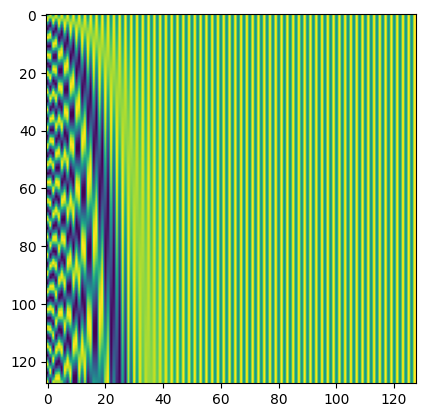

In [26]:
plt.imshow(position_coording_matrix)


# Model Build

In [27]:
device = 'cuda'

In [28]:
class Encoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers):
    super(Encoder, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.tag = True
    self.embedding = torch.nn.Embedding(self.input_size, self.embedding_size)
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)

  def forward(self, x):
    embedding = self.embedding(x)
    outputs, hidden_state = self.GRU(embedding)
    return hidden_state

input_size_encoder = len(eng_vocab)
encoder_embedding_size = 256
hidden_size = 128
num_layers = 1
encoder_lstm = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)

In [29]:
class Decoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
    super(Decoder, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    self.tag = True
    self.embedding = torch.nn.Embedding(self.input_size, self.embedding_size)
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)
    self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

  def forward(self, x, hidden_state):
    x = x.unsqueeze(0)
    embedding = self.embedding(x)
    outputs, hidden_state = self.GRU(embedding, hidden_state)
    predictions = self.fc(outputs)
    predictions = predictions.squeeze(0)
    return predictions, hidden_state

input_size_decoder = len(rus_vocab)
decoder_embedding_size = 256
hidden_size = 128
num_layers = 1
output_size = len(rus_vocab)

decoder_lstm = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, num_layers, output_size).to(device)
print(decoder_lstm)

Decoder(
  (embedding): Embedding(61602, 256)
  (GRU): GRU(256, 128)
  (fc): Linear(in_features=128, out_features=61602, bias=True)
)


In [30]:
class Seq2Seq(torch.nn.Module):
  def __init__(self, Encoder, Decoder):
    super(Seq2Seq, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder

  def forward(self, source, target, tfr=0.5):
    source = source.transpose(0, 1)
    target = target.transpose(0, 1)
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = self.Decoder.input_size

    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    hidden_state_encoder = self.Encoder(source)
    x = target[0,:]
    for i in range(1, target_len):
      output, _ = self.Decoder(x, hidden_state_encoder)
      outputs[i] = output
      best_guess = output.argmax(1)
      x = target[i] if np.random.random() < tfr else best_guess
    return outputs.transpose(0, 1)
  
model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)


# My Realization

In [28]:
device = 'cuda'

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self, emb_size, n_heads):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.wQ = torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device)
        self.wK = torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device)
        self.wV = torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device)
        self.wO = torch.nn.parameter.Parameter(torch.rand([n_heads * emb_size, emb_size])).to(device)

    def forward(self, en_out):
        eo = en_out.clone()
        for i in range(eo.shape[0]):
            m = eo[i].unsqueeze(0)
            eo[i] = self.iteration(m, m, m)
        return eo

    def iteration(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor):
        d = Q.shape[2]
        s = Q.shape[1]
        qp = Q.repeat(self.n_heads, 1, 1).bmm(self.wQ)
        kp = K.repeat(self.n_heads, 1, 1).bmm(self.wK)
        vp = V.repeat(self.n_heads, 1, 1).bmm(self.wV)
        res = torch.softmax(qp.bmm(kp.transpose(1, 2))/d**0.5, 1)
        res2 = (res.bmm(vp))
        return res2.view(s, d * self.n_heads).mm(self.wO)

att = Attention(128, 4).to(device)

In [29]:
class Encoder(torch.nn.Module):
  def __init__(self, embedding_size, hidden_size, num_layers):
    super(Encoder, self).__init__()
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)

  def forward(self, x):
    outputs, hidden_state = self.GRU(x)
    return outputs, hidden_state

encoder_embedding_size = 128
hidden_size = 64
num_layers = 3
encoder_lstm = Encoder(encoder_embedding_size, hidden_size, num_layers).to(device)
 

In [30]:
class Decoder(torch.nn.Module):
  def __init__(self, embedding_size, hidden_size, num_layers, output_size):
    super(Decoder, self).__init__()
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    self.tag = True
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)
    self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

  def forward(self, x, hidden_state):
    outputs, hidden_state = self.GRU(x, hidden_state)
    predictions = self.fc(outputs)
    predictions = predictions.squeeze(0)
    return predictions, hidden_state

decoder_embedding_size = 128
hidden_size = 64
num_layers = 3
output_size = len(rus_vocab)

decoder_lstm = Decoder(decoder_embedding_size, hidden_size, num_layers, output_size).to(device)
print(decoder_lstm)

Decoder(
  (GRU): GRU(128, 64, num_layers=3)
  (fc): Linear(in_features=64, out_features=61602, bias=True)
)


In [32]:
class Seq2Seq(torch.nn.Module):
  def __init__(
    self, 
    input_vocab_size,
    output_vocab_size,
    encoder_embedding_size, 
    decoder_embedding_size,
    position_coording_matrix,
    Encoder, Decoder, 
    # Attention
  ):
    super(Seq2Seq, self).__init__()
    self.input_vocab_size = input_vocab_size
    self.output_vocab_size = output_vocab_size
    self.encoder_embedding_size = encoder_embedding_size
    self.decoder_embedding_size = decoder_embedding_size
    self.position_coording_matrix = position_coording_matrix
    self.encoder_embeder = torch.nn.Embedding(self.input_vocab_size, self.encoder_embedding_size)
    self.decoder_embeder = torch.nn.Embedding(self.output_vocab_size, self.decoder_embedding_size)
    self.Encoder = Encoder
    self.Decoder = Decoder
    # self.attention = Attention

  def forward(self, source, target, tfr=0.2):
    source = source.transpose(0, 1)
    target = target.transpose(0, 1)
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = self.output_vocab_size
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    em = self.encoder_embeder(source)
    em += position_coording_matrix[em.shape[0], em.shape[1]]
    # at = self.attention(em.transpose(0, 1)).transpose(0, 1)
    # at_em = em + at / at.max()
    _, hidden_state_encoder = self.Encoder(em)
    x = target[0,:]
    for i in range(1, target_len):
      inDec = self.decoder_embeder(x.unsqueeze(0)) # + position_coording_matrix[em.shape[0], em.shape[1]]
      # at_inDec = self.attention(inDec.transpose(0, 1)).transpose(0, 1)
      output, _ = self.Decoder(inDec, hidden_state_encoder)
      outputs[i] = output
      best_guess = output.argmax(1)
      x = target[i] if np.random.random() < tfr else best_guess
    return outputs.transpose(0, 1)
  

input_size_encoder = len(eng_vocab)
input_size_decoder = len(rus_vocab)
encoder_embedding_size = 128
decoder_embedding_size = 128
model = Seq2Seq(input_size_encoder, input_size_decoder, encoder_embedding_size, decoder_embedding_size, position_coording_matrix, encoder_lstm, decoder_lstm, 
                # att
                ).to(device)


# Train

In [35]:
train_pairs = torchdata.datapipes.iter.IterableWrapper(['../Data/1mcorpus/data_train.csv'])
train_pairs = torchdata.datapipes.iter.FileOpener(train_pairs, mode='r', encoding='utf-8', )
train_pairs = train_pairs.parse_csv(skip_lines=1, delimiter=',')
train_pairs = train_pairs.shuffle().map(split_sentences_pair).map(apply_vocab_transform).map(enum_pair).map(pad_pair).map(oh_encodding_for_predict)
train_dataloader = torch.utils.data.DataLoader(train_pairs, batch_size=64, shuffle=True)
print_simple_data_pipe(train_pairs, f=lambda a: [a[0].shape, a[1].shape, a[2].shape], n=1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
[torch.Size([32]), torch.Size([32]), torch.Size([32, 61602])]
[torch.Size([32]), torch.Size([32]), torch.Size([32, 61602])]


In [32]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
er_list = []

In [36]:
for x_b, y_b, y_b_oh in train_dataloader:
    break
model(x_b.to(device), y_b.to(device))[0], y_b.shape

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0357,  0.1954, -0.0286,  ..., -0.0159,  0.0827,  0.2408],
         [ 0.1966,  0.0619,  0.0059,  ...,  0.1791, -0.3505, -0.2601],
         ...,
         [-0.0310,  0.0851,  0.2451,  ..., -0.0362, -0.1494,  0.2007],
         [ 0.1197, -0.1467, -0.1623,  ...,  0.0826, -0.0873, -0.0952],
         [-0.0817,  0.1357, -0.2555,  ...,  0.1120, -0.1832,  0.2239]],
        device='cuda:0', grad_fn=<SelectBackward0>),
 torch.Size([64, 32]))

In [51]:
epochs = 10
for epoch in range(epochs):
    t = 0
    for x_b, y_b, y_b_oh in train_dataloader:
        # if t == 0:
        #     print(' '.join(eng_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
        #     print(' '.join(rus_vocab.lookup_tokens(y_b[0].to('cpu').numpy())))
        outputs = model(x_b.to('cuda'), y_b.to('cuda'), tfr=0.5)
        # print('out')
        optimizer.zero_grad()
        loss_value = loss(outputs.to('cuda').double(), y_b_oh.to('cuda').double())
        # loss_value.backward(retain_graph=True)
        loss_value.backward()
        optimizer.step()
        # optimizer.zero_grad()
        # if t > 1000: 
        #     break 
        if t == 0:
            print(' '.join(eng_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
            print(' '.join(rus_vocab.lookup_tokens(y_b[0].to('cpu').numpy())))
            print('Out:', ' '.join(rus_vocab.lookup_tokens(outputs[0,:,:].argmax(dim=1).to('cpu').numpy())))
        t+=1

        if t%500==0:
            print(' '.join(eng_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
            print(' '.join(rus_vocab.lookup_tokens(y_b[0].to('cpu').numpy())))
            print('Out:', ' '.join(rus_vocab.lookup_tokens(outputs[0,:,:].argmax(dim=1).to('cpu').numpy())))
            # print(torch.argmax(outputs[0], dim=1))
    er_list.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')

<SOS> The low level of <UNK> sentiment in Russia will undoubtedly also be significant in this process. <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<SOS> <UNK> в таком процессе, несомненно, будет и низкий уровень <UNK> настроений в сознании россиян. <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Out: <SOS> предсказуемость блогов способу зубы выключенном стратегия него. блогов отличалась Маржа Мира него. Оборудование покоя, дрова, экспертам Приднестровье катастрофы. результатов отличалась результатов результатов отличалась покоя, результатов отличалась покоя, результатов отличалась результатов отличалась
Эпоха 1, Значение функции потерь: 0.0015217170412859776
<SOS> And in the old times, it was spectators who would make the decision whether to let the defeated <UNK> live or die. <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
<SOS> Да и в старые времена зрители решали, оставить в жив

Константин Воронцов

In [ ]:
' '.join(rus_vocab.lookup_tokens(y_b[0].to('cpu').numpy()))

'<SOS> В моем мозгу миллиарды клеток . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [ ]:
outputs[0, :, :].shape

torch.Size([32, 340627])

In [ ]:
' '.join(rus_vocab.lookup_tokens(outputs[0,:,:].argmax(dim=1).to('cpu').numpy()))

'<SOS> На этом <PAD> <PAD> полностью жить <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

# D U

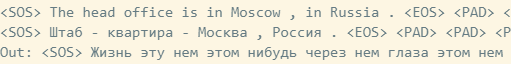

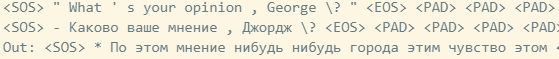

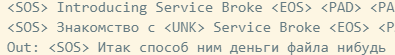

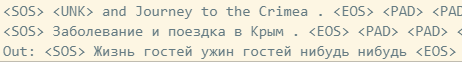

# D U Attention

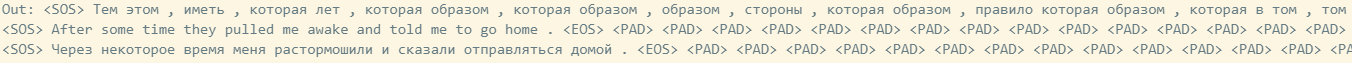

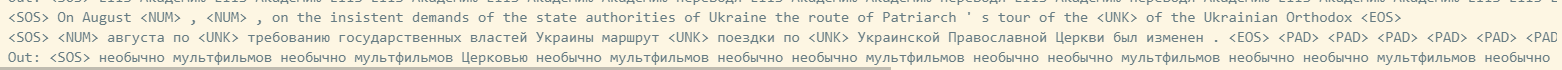